In [5]:
from importlib import reload
import time
import joblib
from pylab import *
from tqdm import tqdm


import sys
sys.path.append("..")

from helper_basic import *
import helper_basic as hp
import helper_finetime as hpt
import helper_visa as vs
reload(vs)



<module 'helper_visa' from 'C:\\Users\\mathusla\\Documents\\MATHUSLA\\JupyterNotebooks\\Hardware\\Keysight\\..\\helper_visa.py'>

# Analysis 1: Coinicidence time resolution

In [37]:
data_save=joblib.load("muon_coinc_ch1_ch2.joblib")
time_series = data_save["metadata"]["time_series"]*1e9
amp2eh = 0.0025 # 2.5 mV/eh

### Try the fit on one event

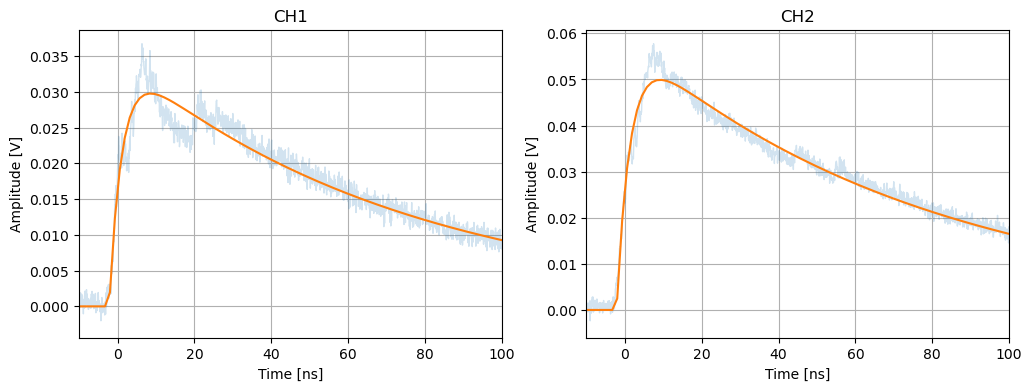

In [152]:
# for i in range(len(data_save[1])):
fig,axs = subplots(1,2,figsize=(12,4))

for iax in [0,1]:
    sca(axs[iax])
    for i in range(1,2):
        x=time_series
        y=-data_save[iax+1][i]
        plot(x, y ,alpha=0.2, linewidth=1)
        
        popt, pcov, info, f = hp.fit_curve(hp.Pulse,x,y, p0=[np.max(y), x[np.argmax(y)], 5., 30], makeplot=True)        
        
    title(f"CH{iax+1}")

    xlim(-10,100)
    xlabel("Time [ns]")
    ylabel("Amplitude [V]")
    grid()
show()



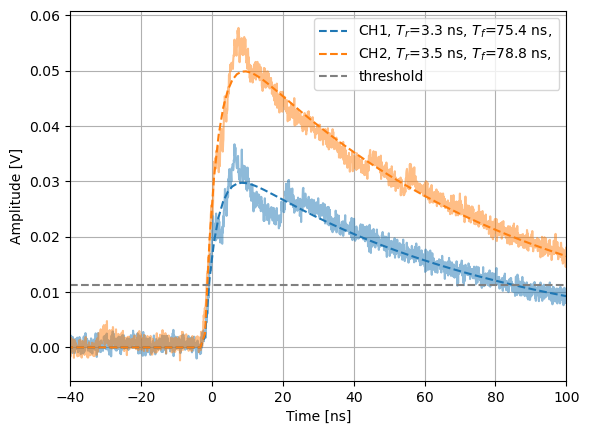

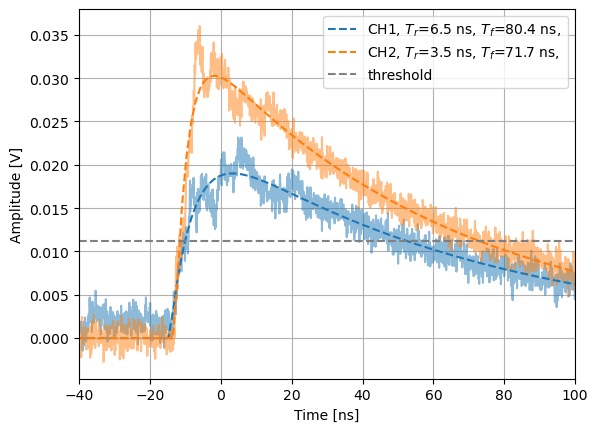

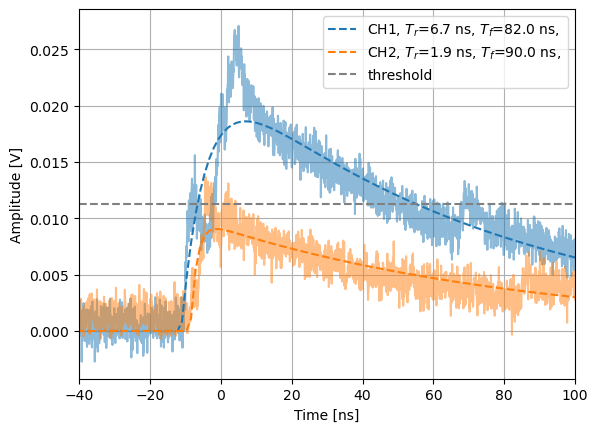

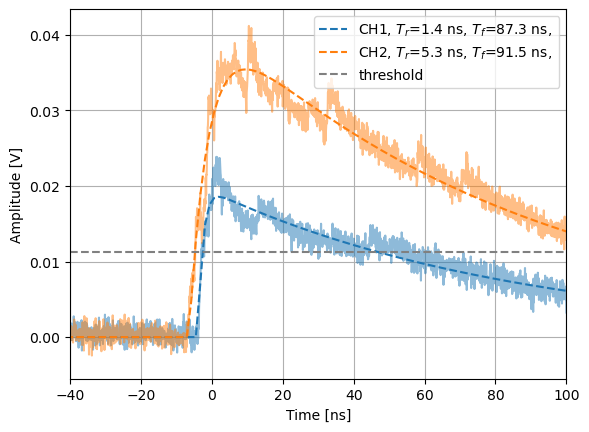

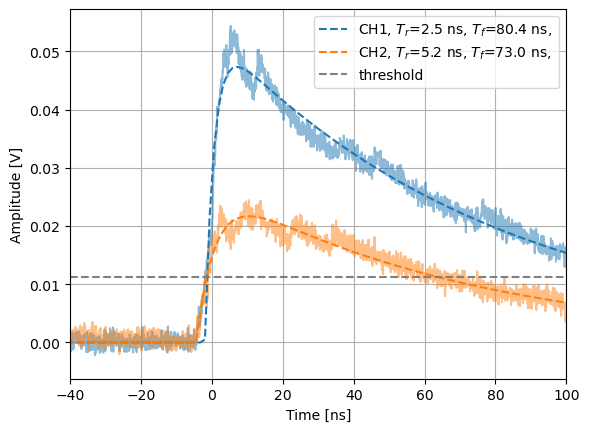

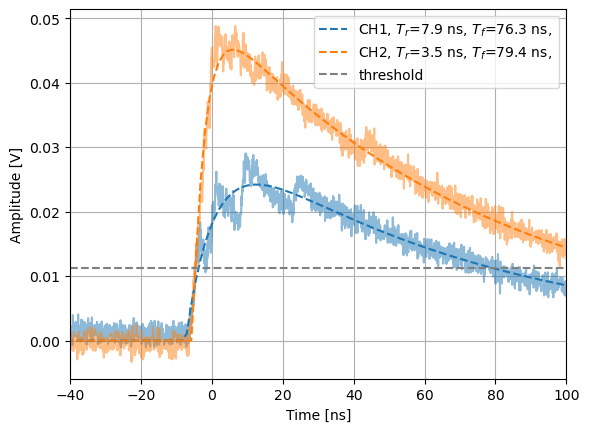

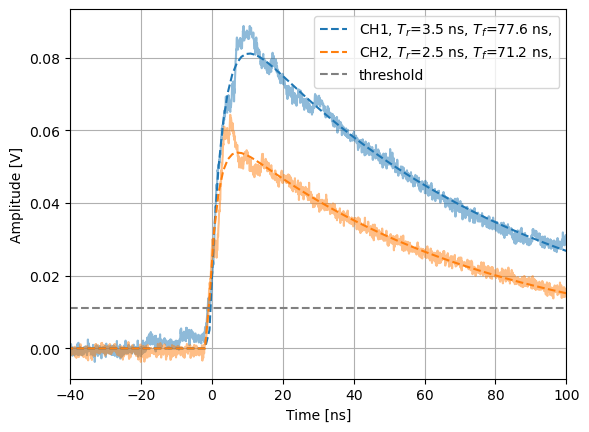

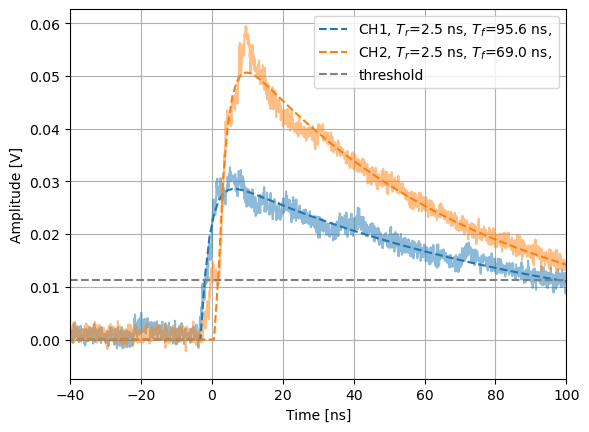

In [153]:

trigger_threshold_edge = amp2eh*4.5


for i in range(20):
    
    if max(-data_save[2][i])>trigger_threshold_edge:
        # CFD trigger
        plot(time_series, -data_save[1][i], alpha=0.5)
        plot(time_series, -data_save[2][i], alpha=0.5)
        
        x=time_series
        y=-data_save[1][i]
        popt, pcov, info, f = hp.fit_curve(hp.Pulse,x,y, p0=[np.max(y), x[np.argmax(y)], 3.5, 70], makeplot=True, color="C0", linestyle="--", label="CH1, $T_r$={popt[2]:.1f} ns, $T_f$={popt[3]:.1f} ns, ")           
        y=-data_save[2][i]
        popt, pcov, info, f = hp.fit_curve(hp.Pulse,x,y, p0=[np.max(y), x[np.argmax(y)], 3.5, 70], makeplot=True, color="C1", linestyle="--", label="CH2, $T_r$={popt[2]:.1f} ns, $T_f$={popt[3]:.1f} ns, ")           
        
        axhline(trigger_threshold_edge, linestyle="--", color="grey", label="threshold")
        xlim(-40,100)
        xlabel("Time [ns]")
        ylabel("Amplitude [V]")
        grid()
        legend()
        show()

In [97]:

trigger_threshold_edge = amp2eh*4.5
trigger_threshold_cfd  = 0.5



process_result = {}
for ch in [1,2]:
    process_result[f"trigger_time_edge_{ch}"]=[]
    process_result[f"trigger_time_cfd_{ch}"]=[]
    process_result[f"trigger_time_fit_{ch}"]=[]
    process_result[f"amplitude_{ch}"]=[]
    process_result[f"amplitude_fit_{ch}"]=[]
    process_result[f"trise_fit_{ch}"]=[]
    process_result[f"tfall_fit_{ch}"]=[]
    process_result[f"fit_chi2_{ch}"]=[]
    

for i in tqdm(range(len(data_save[2]))):
# for i in tqdm(range(1000)):
    for ch in [1,2]:
        x=time_series
        y=-data_save[ch][i]
        dt = (time_series[1]-time_series[0])
        
        

        # Edge trigger:
        trigger_time_edge = (np.argmax( y>trigger_threshold_edge)-2048)*dt
        amplitude = np.max(y)
    
    
        # CFD trigger
        leading_edges = hp.constant_fraction_discriminator(y, 0, trigger_threshold_edge, trigger_threshold_cfd, gauss_filter=8)
        if len(leading_edges)>0:
            trigger_time_cfd = (leading_edges[0][1]-2048)*(time_series[1]-time_series[0])
        else:
            trigger_time_cfd = -999
           
        # Fit
        try:
            popt, pcov, info, f = hp.fit_curve(hp.Pulse,x,y, p0=[np.max(y), x[np.argmax(y)], 3.5, 70], maxfev=1000, makeplot=False, color="C0", linestyle="--", label="CH1, $T_r$={popt[2]:.1f} ns, $T_f$={popt[3]:.1f} ns, ") 
            chi2=np.linalg.norm(info["fvec"])
        except KeyboardInterrupt:
            print("  KeyboardInterrupt. You pressed ctrl c...")
            break                
        except Exception as e: # Any other exception
            # print("  Exception:", str(e)) # Displays the exception without raising it
            popt = [-999, -999, -999, -999]
            chi2=-999
            
        trigger_time_fit = popt[1]
        
        process_result[f"trigger_time_edge_{ch}"].append(trigger_time_edge)
        process_result[f"trigger_time_cfd_{ch}"].append(trigger_time_cfd)
        process_result[f"trigger_time_fit_{ch}"].append(trigger_time_fit)
        process_result[f"amplitude_{ch}"].append(amplitude)
        process_result[f"amplitude_fit_{ch}"].append(popt[0])
        process_result[f"trise_fit_{ch}"].append(popt[2])
        process_result[f"tfall_fit_{ch}"].append(popt[3])
        process_result[f"fit_chi2_{ch}"].append(chi2)        
    
    
for key in process_result:
    process_result[key]=np.array(process_result[key])
    
process_result["charge_min"] = np.min([process_result["amplitude_fit_1"],process_result["amplitude_fit_2"]],axis=0)/amp2eh
charge_1 = process_result["amplitude_fit_1"]/amp2eh
charge_2 = process_result["amplitude_fit_2"]/amp2eh
dt_edge = process_result["trigger_time_edge_1"]-process_result["trigger_time_edge_2"]
dt_cfd = process_result["trigger_time_cfd_1"]-process_result["trigger_time_cfd_2"]
dt_fit = process_result["trigger_time_fit_1"]-process_result["trigger_time_fit_2"]

 77%|████████████████████████████████████████████████████████████▎                 | 6189/8000 [02:43<00:46, 39.33it/s]C:\Users\mathusla\Documents\MATHUSLA\JupyterNotebooks\Hardware\Keysight\..\helper_basic.py:47: RuntimeWarning: overflow encountered in true_divide
  kernel_normed = kernel/np.max(kernel)
100%|██████████████████████████████████████████████████████████████████████████████| 8000/8000 [03:32<00:00, 37.73it/s]


Coincidence events 3358


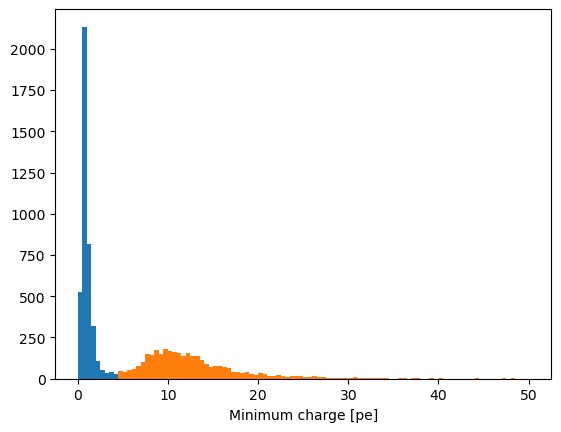

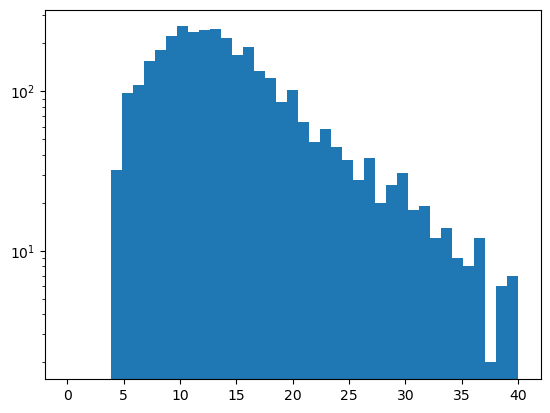

In [166]:
mask_basic = process_result["charge_min"]>0
mask_amp = process_result["charge_min"]>4.5
hist(process_result["charge_min"][mask_basic], bins=100,range=(0,50));
hist(process_result["charge_min"][mask_basic&mask_amp], bins=100,range=(0,50));
# hist(charge_1[mask_basic&mask_amp], bins=100,range=(0,50));
# hist(charge_2[mask_basic&mask_amp], bins=100,range=(0,50));
xlabel("Minimum charge [pe]")
print("Coincidence events",sum(mask_basic&mask_amp))
show()

hist(process_result[f"amplitude_fit_2"][mask_basic&mask_amp]/amp2eh, range=(0,40),bins=41);
yscale("log")
show()

Text(0, 0.5, 'Trigger delay [ns]')

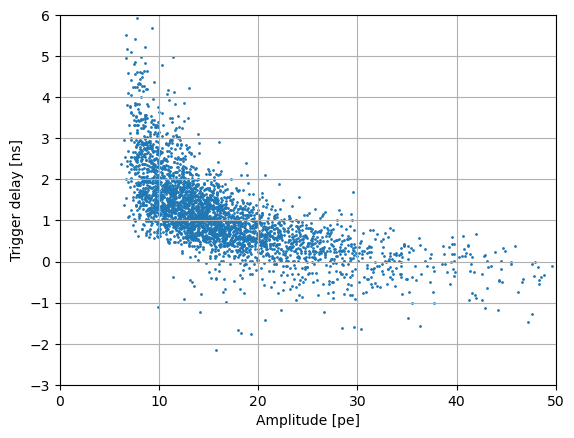

In [165]:
scatter(process_result[f"amplitude_fit_1"][mask_basic&mask_amp]/amp2eh, -(process_result["trigger_time_fit_1"]-process_result["trigger_time_edge_1"])[mask_basic&mask_amp], s=1);
xlim(0,50)
ylim(-3,6)
grid()
xlabel("Amplitude [pe]")
ylabel("Trigger delay [ns]")

3.4231518429420884

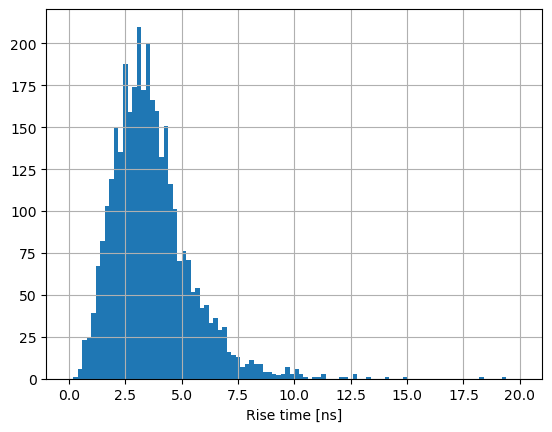

In [140]:
hist(process_result[f"trise_fit_2"][mask_basic&mask_amp],bins=100, range=(0,20));
xlabel("Rise time [ns]")
grid()
np.median(process_result[f"trise_fit_2"][mask_basic&mask_amp])
show()

scatter(process_result[f"amplitude_fit_2"][mask_basic&mask_amp], process_result[f"trise_fit_2"][mask_basic&mask_amp],s=4,alpha=0.3);
ylim(0,20)
xlabel("Amplitude [ns]")
ylabel("Rise time [ns]")


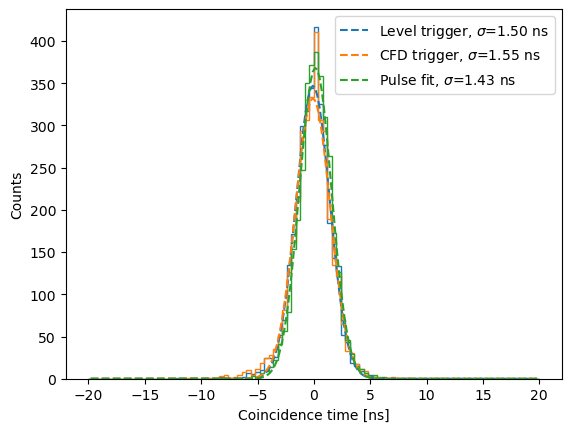

In [105]:
mask = mask_basic&mask_amp
h1 = hist(dt_edge[mask],bins=100,range=(-20,20),histtype="step")#, label="Level trigger");
h2 = hist(dt_cfd[mask], bins=100,range=(-20,20),histtype="step")#, label="CFD trigger");
h3 = hist(dt_fit[mask], bins=100,range=(-20,20),histtype="step")#, label="Fit");


popt, pcov, info, f = hp.fit_hist("gauss", h1, label="Level trigger, $\sigma$={popt[2]:.2f} ns", color="C0", linestyle="--");
popt, pcov, info, f = hp.fit_hist("gauss", h2, label="CFD trigger, $\sigma$={popt[2]:.2f} ns", color="C1", linestyle="--");
popt, pcov, info, f = hp.fit_hist("gauss", h3, label="Pulse fit, $\sigma$={popt[2]:.2f} ns", color="C2", linestyle="--");


legend()
xlabel("Coincidence time [ns]")
ylabel("Counts")
legend()

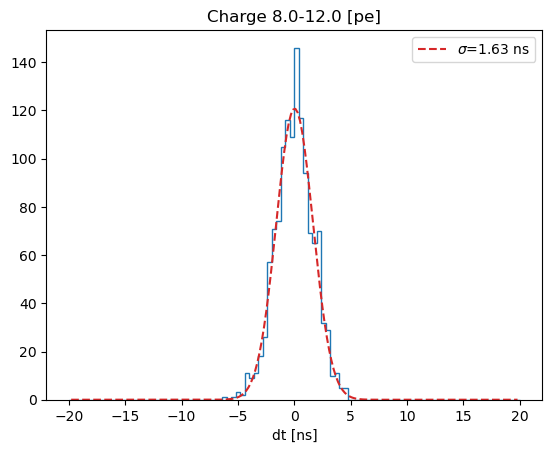

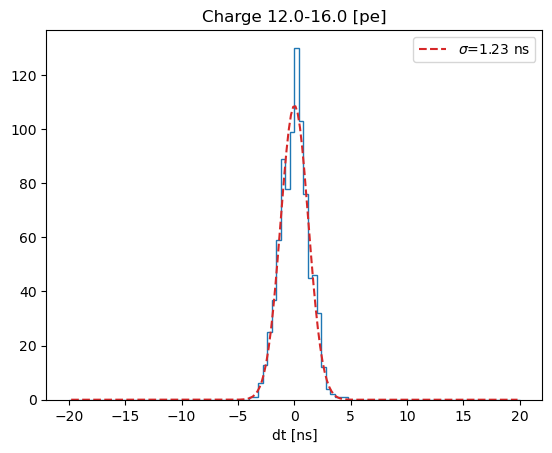

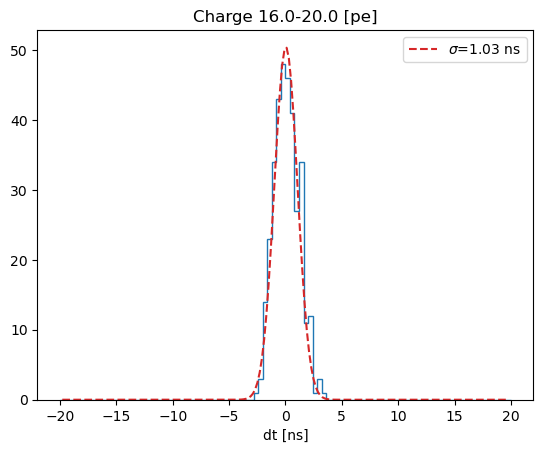

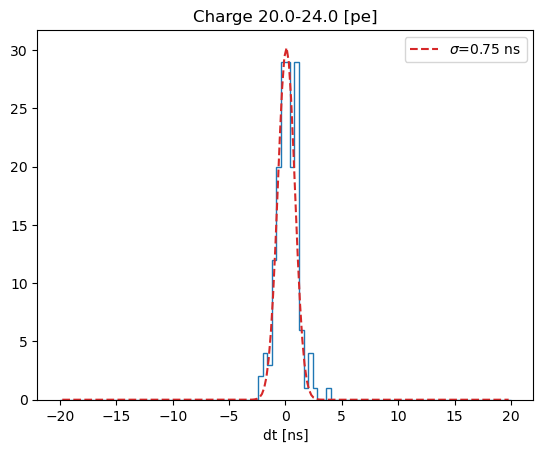

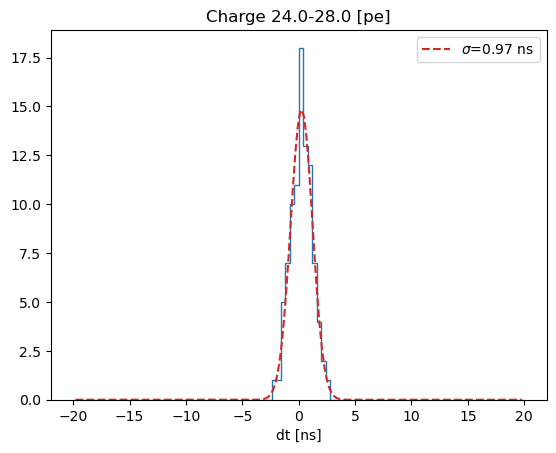

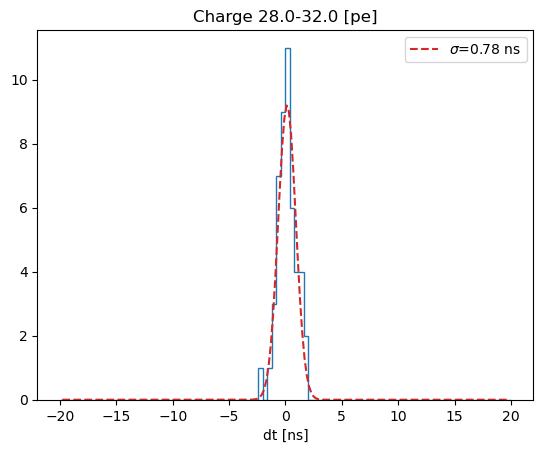

(0.0, 1.1908785187804785)

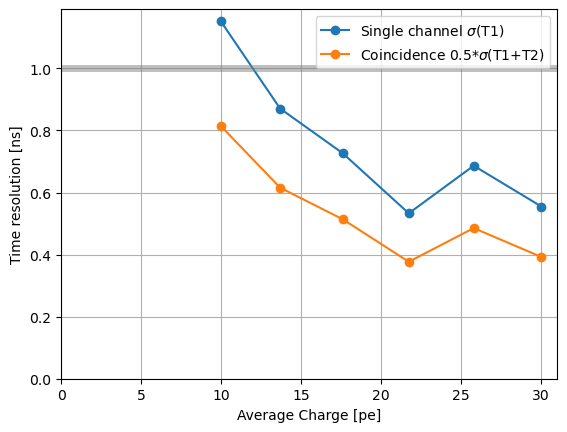

In [125]:
list_charge=[]
list_sigma = []
for i in range(6):
    gap=4
    mask = mask_basic&mask_amp  & (np.abs(process_result["charge_min"]-(10+i*gap))<(gap/2))
    
    h = hist(dt_edge[mask],bins=100,range=(-20,20),histtype="step")#, label="Level trigger");
    popt, pcov, info, f = hp.fit_hist("gauss", h, label="$\sigma$={popt[2]:.2f} ns", color="C3", linestyle="--");
    legend()
    title(f"Charge {10+gap*i-gap/2}-{10+gap*i+gap/2} [pe]")
    xlabel("dt [ns]")
    show()
    
    avg_charge = np.mean(process_result["charge_min"][mask])
    list_charge.append(avg_charge)
    list_sigma.append(popt[2])    
    
list_charge=np.array(list_charge)
list_sigma=np.array(list_sigma)
plot(list_charge, list_sigma/np.sqrt(2), marker="o", label="Single channel $\sigma$(T1)")
plot(list_charge, list_sigma/2, marker="o", label="Coincidence 0.5*$\sigma$(T1+T2)")
xlabel("Average Charge [pe]")
ylabel("Time resolution [ns]")
legend()
grid()
axhline(1, linewidth=5, color="grey", alpha=0.5)
# legend()
xlim(0,)
ylim(0,)

# Analysis 2: Waveform difference

In [83]:
filenames = ["waveform_laser.joblib","waveform_scintillator.joblib","waveform_wlsf_laser.joblib","waveform_wlsf_scintillator.joblib"]
labels = ["Laser", "Scintillator", "WLS+Laser", "WLS+Scintillator"]

In [37]:
data_save=joblib.load(filenames[3])
time_series = data_save["metadata"]["time_series"]*1e9

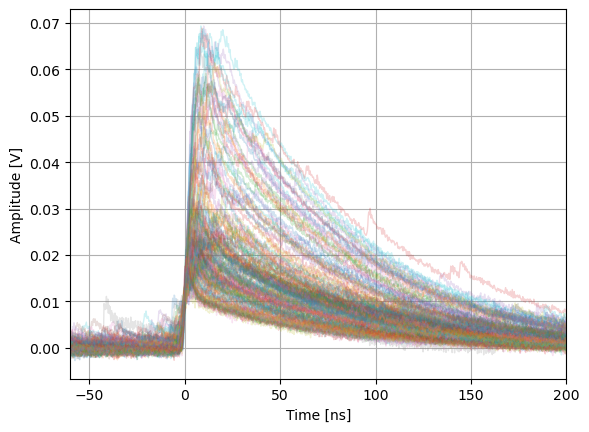

In [69]:
# for i in range(len(data_save[1])):
trace_original = []
trace_aligned = []
for i in range(len(data_save[1])):
    trace = data_save[1][i]
    trace-=np.mean(trace[:1600])
    trace = -trace
    trace/=15.8
    if (max(trace)>0.07) or  (max(trace)<0.01) or (min(trace)<-0.005):
        continue
        
    leading_edges = constant_fraction_discriminator(trace, 0, 0.01, 0.5, gauss_filter=4)
    trigger_offset = leading_edges[0][1]-2048
    trace_original.append(trace)
    trace = np.roll(trace, -trigger_offset)
    trace_aligned.append(trace)
    
    if i <200:
        plot(time_series, trace,alpha=0.2, linewidth=1)

xlim(-60,200)
xlabel("Time [ns]")
ylabel("Amplitude [V]")
grid()

Text(0.5, 0, 'Time [ns]')

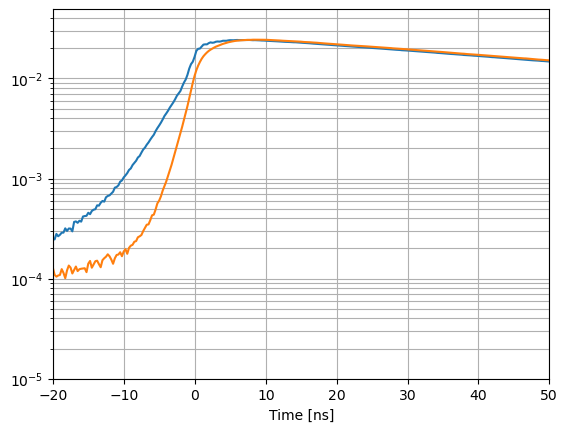

In [81]:
trace_original_avg = np.mean(trace_original, axis=0)
trace_aligned_avg = np.mean(trace_aligned, axis=0)
plot(time_series, trace_original_avg)
plot(time_series, trace_aligned_avg)

yscale("log")
xlim(-20,50)
ylim(1e-5,)
grid(which="both")
xlabel("Time [ns]")

In [82]:
trace_aligned_avg_all = []
for i in range(len(filenames)):
    data_save=joblib.load(filenames[i])
    time_series = data_save["metadata"]["time_series"]*1e9
    
    trace_aligned = []
    for i in range(len(data_save[1])):
        trace = data_save[1][i]
        trace-=np.mean(trace[:1600])
        trace = -trace
        trace/=15.8
        if (max(trace)>0.07) or  (max(trace)<0.01) or (min(trace)<-0.005):
            continue

        leading_edges = constant_fraction_discriminator(trace, 0, 0.01, 0.5, gauss_filter=4)
        trigger_offset = leading_edges[0][1]-2048
        trace = np.roll(trace, -trigger_offset)
        trace_aligned.append(trace)   
        
    trace_aligned_avg = np.mean(trace_aligned, axis=0)
    trace_aligned_avg_all.append(trace_aligned_avg)

Text(0, 0.5, 'Normalized amplitude')

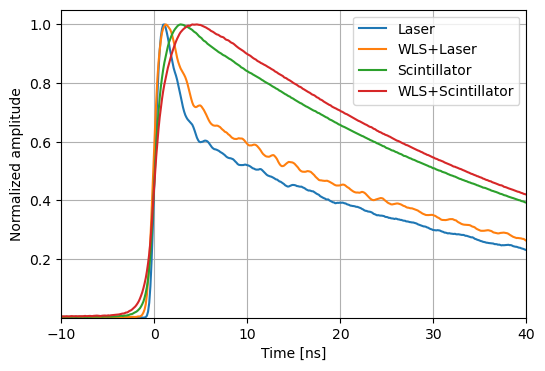

In [184]:
figure(figsize=(6,4))
for i in [0,2,1,3]:
    trace = trace_aligned_avg_all[i]
    plot(time_series, trace/max(trace),label=labels[i])
    
legend()

# yscale("log")
xlim(-10,40)
ylim(1e-5,)
grid(which="both")
xlabel("Time [ns]")
ylabel("Normalized amplitude")